In [1]:
import random
import numpy as np

from deap import base
from deap import creator
from deap import tools

import matplotlib.pyplot as plt
plt.style.use("seaborn")

%matplotlib inline

In [2]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

# Setup the System
- genome is now 3 params: distance OH1, Distance Oh2, angle H1OH2.
- Molecule will always be in xy plane


In [3]:
toolbox = base.Toolbox()

def init_individual():
    return [random.gauss(1, 0.4), random.gauss(1, 0.4), random.gauss(2, 0.4)]


toolbox.register("init_individual", tools.initIterate, 
                 creator.Individual, init_individual)

toolbox.register("init_population", tools.initRepeat, 
                 list, toolbox.init_individual)

In [4]:
from pyscf.gto import Mole
from pyscf.scf import RHF

def build_molecule_from_genome(genome):
    
    atoms = [
        ("O", 0, 0, 0),
        ("H", genome[0], 0, 0),
        ("H", genome[1] * np.cos(genome[2]), genome[1] * np.sin(genome[2]), 0)
    ]
    
    mol = Mole()
    mol.atom = atoms
    #mol.basis = "6-31++g**"
    mol.basis = "sto-3g"
    mol.build()
    return mol
    
def evaluateFitness(individual):
    
    mol = build_molecule_from_genome(individual)
    
    mf = RHF(mol)
    mf.verbose = 0
    E = mf.scf()
    
    # this shit has to be a tuple!!
    return E,

toolbox.register("evaluate", evaluateFitness)

/home/jo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.05) # flip gene with 0.05 % probability
toolbox.register("select", tools.selTournament, tournsize=3)

# Do the Optimazation 

In [6]:
PROBABILITY_CROSSING = 0.5
PROBABILITY_MUTATION = 0.2

MAX_ITERATIONS = 10

CONVERGENCE_THRESHOLD = 1e-7

E_old = 1e10

In [7]:
SIZE_POPULATION = 50

population = toolbox.init_population(n=SIZE_POPULATION)

In [21]:
fitnesses = list(map(toolbox.evaluate, population))

for ind, fit in zip(population, fitnesses):
    ind.fitness.values = fit

In [37]:
distribution_lower, distribution_upper = min(fitnesses)[0], max(fitnesses)[0]
number_of_bins = 60

fitness_distribution, bins = np.histogram(
    np.array(fitnesses).reshape(SIZE_POPULATION), 
    bins=number_of_bins, 
    range=(distribution_lower, distribution_upper)
)

def calculate_fitness_distribution(fitnesses):
    fitness_distribution = np.histogram(
        np.array(fitnesses).reshape(SIZE_POPULATION), 
        bins=number_of_bins, 
        range=(distribution_lower, distribution_upper)
    )[0]
    return fitness_distribution

In [10]:
best_ind = tools.selBest(population, 1)[0]
print("Pre:")
print(best_ind, best_ind.fitness.values)

Pre:
[1.000264014221176, 1.0291761795308247, 1.4899554183105037] (-74.95474304633743,)


In [11]:
# create a list of fitness values
fitness_values = [ind.fitness.values[0] for ind in population]

# Begin the evolution
for i in range(MAX_ITERATIONS):

    # Select next generation
    offspring = toolbox.select(population, len(population))
    offspring = list(map(toolbox.clone, offspring))

    # do cross over
    for child1, child2 in zip(offspring[::2], offspring[1::2]):

        if random.random() < PROBABILITY_CROSSING:
            toolbox.mate(child1, child2)

            del child1.fitness.values
            del child2.fitness.values
            
    # do mutation
    for mutant in offspring:
        if random.random() < PROBABILITY_MUTATION:
            toolbox.mutate(mutant)
            del mutant.fitness.values
    
    # recalculate fitness values of mates and mutants
    invalid_individuals = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_individuals)
    for ind, fit in zip(invalid_individuals, fitnesses):
        ind.fitness.values = fit
    
    population[:] = offspring
    
    # update list of fitness value
    fitness_values = [ind.fitness.values[0] for ind in population]
    
    # updates fitness distributions
    fitness_distribution += calculate_fitness_distribution(fitness_values) 
    
    #E = sum(fitness_values) / len(fitness_values)
    E = sum(fitness_values) / float(SIZE_POPULATION)
    print("Generation: " + str(i+1))
    print(E, np.abs(E_old-E))
    
    
    if np.abs(E - E_old) < CONVERGENCE_THRESHOLD:
        print("\n\nCONVERGED!\n")
        break

    else:
        E_old = E
        
    

Generation: 1
-74.8318568519291 10000000074.831858
Generation: 2
-74.9084005789098 0.07654372698070233
Generation: 3
-74.94555079104626 0.037150212136452865
Generation: 4
-74.95612860023255 0.010577809186287368
Generation: 5
-74.94887166868575 0.007256931546791634
Generation: 6
-74.92290670232744 0.025964966358316133
Generation: 7
-74.96457184119573 0.04166513886829648
Generation: 8
-74.95943334014144 0.0051385010542901455
Generation: 9
-74.9643363984124 0.00490305827095483
Generation: 10
-74.96511417201559 0.0007777736031897575


# Checking the Result 

In [42]:
bins[:-1], fitness_distribution

(array([-74.96511417, -74.96511417, -74.96511417, -74.96511417,
        -74.96511417, -74.96511417, -74.96511417, -74.96511417,
        -74.96511417, -74.96511417, -74.96511417, -74.96511417,
        -74.96511417, -74.96511417, -74.96511417, -74.96511417,
        -74.96511417, -74.96511417, -74.96511417, -74.96511417,
        -74.96511417, -74.96511417, -74.96511417, -74.96511417,
        -74.96511417, -74.96511417, -74.96511417, -74.96511417,
        -74.96511417, -74.96511417, -74.96511417, -74.96511417,
        -74.96511417, -74.96511417, -74.96511417, -74.96511417,
        -74.96511417, -74.96511417, -74.96511417, -74.96511417,
        -74.96511417, -74.96511417, -74.96511417, -74.96511417,
        -74.96511417, -74.96511417, -74.96511417, -74.96511417,
        -74.96511417, -74.96511417, -74.96511417, -74.96511417,
        -74.96511417, -74.96511417, -74.96511417, -74.96511417,
        -74.96511417, -74.96511417, -74.96511417, -74.96511417]),
 array([ 0,  1,  0,  0,  0,  0,  0,  0

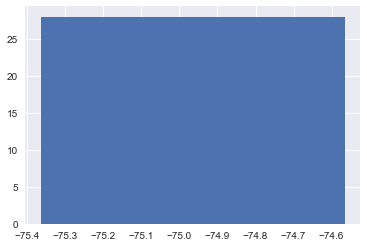

In [43]:
#plt.hist(fitness_distribution, bins=number_of_bins, range=(distribution_lower, distribution_upper))
plt.bar(bins[:-1], fitness_distribution)git
plt.show()

In [14]:
best_ind = tools.selBest(population, 1)[0]
print("Distances: \n - {0}\n - {1}".format(best_ind[0], best_ind[1]))
print("Angle: {0}".format(best_ind[2] * 360 / (2 * np.pi) % 360))
print("Energy: {0}".format(best_ind.fitness.values))

Distances: 
 - 0.9931241485898789
 - 0.9662329644069355
Angle: 101.86124268974952
Energy: (-74.96511417201569,)


In [15]:
mol = build_molecule_from_genome(best_ind)
mol.atom

[('O', 0, 0, 0),
 ('H', 0.9931241485898789, 0, 0),
 ('H', -0.1986016811378515, 0.9456021963573442, 0)]

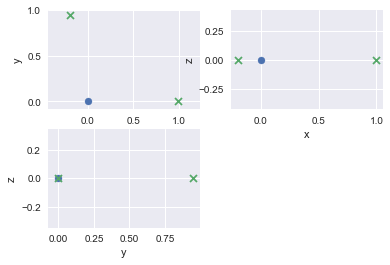

In [16]:
import matplotlib.pylab as plt

x = [t[1] for t in mol.atom]
y = [t[2] for t in mol.atom]
z = [t[3] for t in mol.atom]

lower, upper = -1.5, 1.5

plt.subplot(2, 2, 1)
plt.scatter(x[0], y[0], label="C")
plt.scatter(x[1:], y[1:], marker="x", label="H")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(lower, upper)
plt.ylim(lower, upper)
plt.axis("equal")

plt.subplot(2, 2, 2)
plt.scatter(x[0], z[0], label="C")
plt.scatter(x[1:], z[1:], marker="x", label="H")
plt.xlabel("x")
plt.ylabel("z")
plt.xlim(lower, upper)
plt.ylim(lower, upper)
plt.axis("equal")

plt.subplot(2, 2, 3)
plt.scatter(y[0], z[0], label="C")
plt.scatter(y[1:], z[1:], marker="x", label="H")
plt.xlabel("y")
plt.ylabel("z")
plt.xlim(lower, upper)
plt.ylim(lower, upper)
plt.axis("equal")

plt.show()